<a href="https://colab.research.google.com/github/ajlukasiewicz/Team_9_MacLearn/blob/main/Prediction_of_plant_associated_bacteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting plant associated bacterial from genetic markers**

The soil microbiome is a diverse and sensitive assembly of organisms (bacterial and fungal) whose composition changes relative to the soil type, location, and even the plant species. 

Based on a large dataset of 3800, well-curated, bacterial genomes (Levy et. al., 2017) we aimed to construct a classifier of bacteria, based on three major feature families: Carbohydrate Associated Enzyme families, COG counts, and the % of horizontally transmitted genes within each bacterial genome. 

Carbohydrate associated enzymes were identified for each genome using the DBCan4 tool, and COG percentages were calculated from the metadata provided by Levy et. al., 2017. 

Authors of this project are Muyoung Lee (ML), Sarah Coleman (SC), and Alexandra Lukasiewicz (AL) to fulfill the requirements of our final project in SDS 384, Scientific Machine Learning. 

We each have contributed equally to the review, curation, writing and interpretation of this project. This colab document represents the aggregate of all individual scripts used to modify, train, tune, and evaluate multiple models. For more information on our individual approaches, please see the jupyter notebooks in each of our git branches. 

We have included author contributions in the #comments for each script section.

In [8]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

#normalization
from sklearn.preprocessing import StandardScaler

#splitting and feature selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import xgboost as xgb

#evaluation
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, PrecisionRecallDisplay, precision_recall_curve

#shhhhhh
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#functions
def soilrm(df):
    df2 = df[df["Classification"] != "soil"]
    soil = df[df["Classification"] == "soil"]
    return df2, soil

In [ ]:
#set matplotlib theme 
custom_style = {
    'figure.figsize': (8, 6),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'serif',
    'font.serif': ['arial'],
    'text.color': '#333333',
    'axes.edgecolor': '#CCCCCC',
    'axes.linewidth': 1.5,
    'grid.linewidth': 0.5,
    'grid.color': '#DDDDDD',
}


In [2]:
#AL
#import data
#from google.colab import drive
#drive.mount('/content/drive')
#data_dir = "/content/drive/MyDrive/Datasets/"

#dbcan = pd.read_csv(data_dir + "dbcan_result.3772genomes.matrix.divided_by_gene_counts.tsv", sep="\t")
#cog = pd.read_csv(data_dir + "cog_ratios.csv")

#metadata = pd.read_csv(data_dir + "jgi_metadata_processed.csv")
metadata = pd.read_csv("https://raw.githubusercontent.com/ajlukasiewicz/Team_9_MacLearn/main/Data/jgi_metadata_processed.csv")

#overlapping features from all three of our feature selection approaches
#union_features = pd.read_csv(data_dir + "overlapping_features.csv")
union_features = pd.read_csv("https://raw.githubusercontent.com/ajlukasiewicz/Team_9_MacLearn/main/Data/overlapping_features.csv")
union_features = union_features['elements'].values

In [ ]:
#AL
#modify and merge hgt% to dbcan dataset
#dbcan = dbcan.rename(columns = {"taxonID" : "2016_taxon_oid"})

#add hgt % from metadata to dbcan dataset
#dbcan = pd.merge(dbcan, cog[['2016_taxon_oid', 'Horizontally_Transferred_%']], on='2016_taxon_oid', how='left')

In [ ]:
#AL
#remove soil bacteria from all three datasets 
#cog, soilcog = soilrm(cog)
#dbcan, soilcan = soilrm(dbcan)

In [ ]:
#AL
#merge the dbcan and cog datasets
#columns = ['Classification', 'Horizontally_Transferred_%', "Gene_Count___*_assembled", "Unnamed: 0"]
#merged = pd.merge(dbcan, cog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

#merged.head()

In [ ]:
#merged.to_csv('merged.tsv', sep="\t", index=False)
#soil_dataset = pd.merge(soilcan, soilcog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')
#soil_dataset.to_csv("soil_dataset.tsv", sep="\t", index=False)

In [3]:
merged = pd.read_csv("https://utexas.box.com/shared/static/21oborsfx8kzhushr24vgfc69gpf4ztp.tsv", sep="\t")
merged.head()

,2016_taxon_oid,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
soil_dataset = pd.read_csv("https://raw.githubusercontent.com/ajlukasiewicz/Team_9_MacLearn/main/Data/soil_dataset.tsv", sep="\t")
soil_dataset.head()

,2016_taxon_oid,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,2534682017,Acinetobacter,soil,soil,0.000267,0.000000,0.000000,0.000267,0.000267,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2534682020,Acinetobacter,soil,soil,0.000257,0.000000,0.000000,0.000257,0.000257,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2576861110,Acinetobacter,soil,soil,0.000497,0.000000,0.000248,0.000248,0.000248,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,648028004,Acinetobacter,soil,soil,0.000252,0.000000,0.000000,0.000505,0.000252,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2502894011,Actinobacteria,soil,soil,0.000128,0.000641,0.000000,0.000256,0.000128,0.000128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#AL
#x and y variables
variables = merged.columns[:4]
classif = merged['Classification']

scaler = StandardScaler()
merged_n = pd.DataFrame(scaler.fit_transform(merged.iloc[:,4:]), columns = merged.iloc[:,4:].columns)
merged_n.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738


The classifications appear to be roughly 65% NPA, and 35% PA. We therefore stratify our training and testing datasets by the classification



In [6]:
#Train test split dataset, scaled by classification ()
X_train, X_test, y_train, y_test = train_test_split(merged_n,
                                                    classif, test_size=0.33,
                                                    random_state=42, 
                                                    stratify=classif)

In [7]:
#ML, AL, SC
#filter the main, training, and test datasets by the union features
X = merged_n[union_features]
X_train = X_train[union_features]
X_test = X_test[union_features]

In [13]:
#ML 
#Decision tree model building and evaluation 

'''
twenty = [i for i in range(1, 20+1)]
accuracies = {}

for depth in twenty:
  for _min_samples_leaf in twenty:
    clf1 = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
    clf1.fit(X_train, y_train)
    y_pred1 = clf1.predict(X_test)
    accuracies[(depth, _min_samples_leaf)] = metrics.accuracy_score(y_test, y_pred1)

sorted_accuracies = sorted(accuracies.items(), key=lambda x:x[1], reverse=True)
depth, _min_samples_leaf = sorted_accuracies[0][0]
print(depth, _min_samples_leaf)
'''
depth, _min_samples_leaf = 11, 5  # Based on the former result, to save time
clf1 = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
clf1.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)

# Accuracy scores measured with the test set and train set
print(metrics.accuracy_score(y_test, y_pred1))
print(metrics.accuracy_score(y_train, clf1.predict(X_train)))

dt_depth = depth
dt_min_samples_leaf = _min_samples_leaf

0.8477251624883937
0.9624542124542125


In [14]:
#ML
#Random Forest model building and evaluation

'''
twenty = [i for i in range(1, 20+1)]
accuracies = {}

for _n_estimators in [50, 100, 150]:
  for depth in twenty:
    for _min_samples_leaf in twenty:
      clf2 = RandomForestClassifier(n_estimators=_n_estimators, max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
      clf2.fit(X_train, y_train.values.ravel())
      y_pred2 = clf2.predict(X_test)
      accuracies[(_n_estimators, depth, _min_samples_leaf)] = metrics.accuracy_score(y_test, y_pred2)

sorted_accuracies = sorted(accuracies.items(), key=lambda x:x[1], reverse=True)
_n_estimators, depth, _min_samples_leaf = sorted_accuracies[0][0]
print(_n_estimators, depth, _min_samples_leaf)
'''
_n_estimators, depth, _min_samples_leaf = 50, 18, 1 # Based on the former result, to save time
clf2 = RandomForestClassifier(n_estimators=_n_estimators, max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
clf2.fit(X_train, y_train.values.ravel())
y_pred2 = clf2.predict(X_test)

# Accuracy scores measured with the test set and train set
print(metrics.accuracy_score(y_test, y_pred2))
print(metrics.accuracy_score(y_train, clf2.predict(X_train)))

RF_n_estimators, RF_depth, RF_min_samples_leaf = _n_estimators, depth, _min_samples_leaf

0.8885793871866295
0.9995421245421245


In [15]:
#ML
#XGBoost model building and evaluation
XGB_y_test = y_test.replace("PA", 1).replace("NPA", 0)
XGB_y_train = y_train.replace("PA", 1).replace("NPA", 0)

'''
from sklearn.model_selection import GridSearchCV

#XGBoost model building and evaluation
XGB_y_test = y_test.replace("PA", 1).replace("NPA", 0)
XGB_y_train = y_train.replace("PA", 1).replace("NPA", 0)

# define the parameter grid
param_grid = {
    'max_depth': range(1, 11),
    'n_estimators': [100, 150]
}

# create the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)

# fit the GridSearchCV object to the data
grid_search.fit(X_train, XGB_y_train)

# print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)
'''

_n_estimators, depth = 150, 2 # Based on the former result, to save time

clf3 = xgb.XGBClassifier(objective="binary:logistic", n_estimators=_n_estimators, max_depth=depth, random_state=42)
clf3.fit(X_train, XGB_y_train)
y_pred3 = clf3.predict(X_test)

# Accuracy scores measured with the test set and train set
print(metrics.accuracy_score(XGB_y_test, y_pred3))
print(metrics.accuracy_score(XGB_y_train, clf3.predict(X_train)))

XGB_n_estimators, XGB_depth = _n_estimators, depth

0.8885793871866295
0.9977106227106227


In [16]:
#ML

# To check whether the first column from predict_proba is about PA or not (NPA).
#Tree
print(clf1.classes_)
#RF
print(clf2.classes_)
# XGBoost
print(clf3.classes_)

['NPA' 'PA']
['NPA' 'PA']
[0 1]


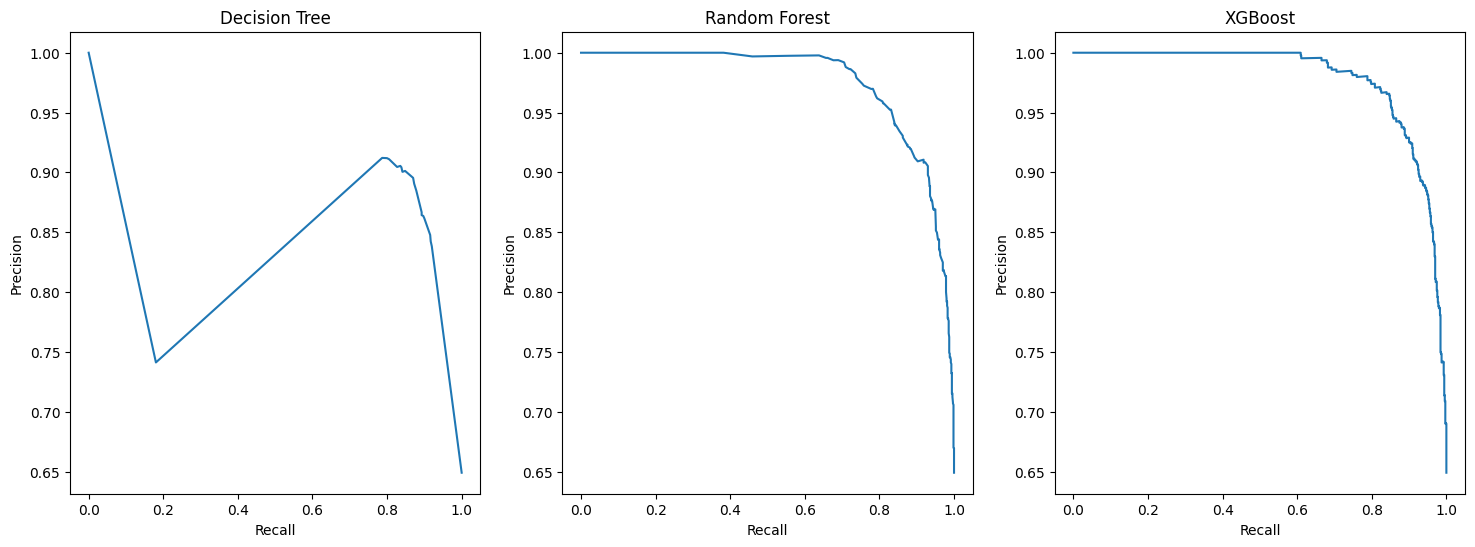

In [17]:
#ML
#Random Forest and Decision Tree PR curves


#generate curves
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, clf1.predict_proba(X_test)[:,0], pos_label="NPA")
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, clf2.predict_proba(X_test)[:,0], pos_label="NPA")
precision_3, recall_3, thresholds_3 = precision_recall_curve(XGB_y_test, clf3.predict_proba(X_test)[:,0], pos_label=0)

#plot
fig, ax = plt.subplots(1,3, figsize=(18, 6))

ax[0].plot(recall_1, precision_1)
ax[1].plot(recall_2, precision_2)
ax[2].plot(recall_3, precision_3)

ax[0].set_title("Decision Tree")
ax[1].set_title("Random Forest")
ax[2].set_title("XGBoost")

ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[2].set_xlabel("Recall")
ax[2].set_ylabel("Precision")

plt.show()

In [9]:
#AL
#train and evaluate KNeighbors Classification
#find minimum variance using k fold cross validation

#list of feature k to try
neighbors = range(1,100)
accuracy = {"n": [], "accuracy": [], "std": []}

skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

for n in neighbors:
    #fit using KNeighbors
    KNC = KNeighborsClassifier(n_neighbors = n)
    
    #calculate cross val scores
    val_scores = cross_val_score(estimator= KNC,  X= X_train, y= y_train, cv= skf)

    #log accuracy
    accuracy['n'].append(n)
    accuracy['accuracy'].append(val_scores.mean())
    accuracy['std'].append(val_scores.std())

accuracy_dataframe = pd.DataFrame.from_dict(accuracy)

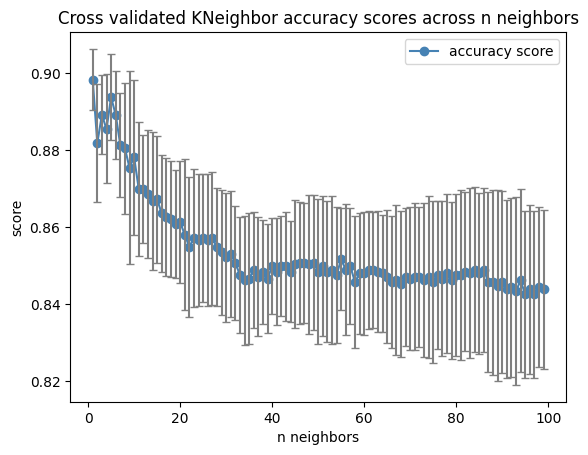

In [10]:
#plot dataframe 
plt.plot(accuracy_dataframe['n'], accuracy_dataframe['accuracy'],'o-', label='accuracy score', color = 'steelblue')
plt.errorbar(accuracy_dataframe['n'], accuracy_dataframe['accuracy'], yerr=accuracy_dataframe['std'], fmt='none', color='gray', capsize=3)

# add a title and labels to the plot
plt.xlabel('n neighbors')
plt.ylabel('score')
plt.title('Cross validated KNeighbor accuracy scores across n neighbors')

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

In [11]:
#AL top accuracy with minimum variability
accuracy_dataframe.sort_values(by = ["accuracy",'std'], ascending = [False,True])[:10]

,n,accuracy,std
0,1,0.898352,0.008001
4,5,0.893774,0.011160
2,3,0.889194,0.010291
5,6,0.889193,0.011366
3,4,0.885532,0.014172
1,2,0.881874,0.015249
6,7,0.881415,0.013490
7,8,0.880494,0.016971
9,10,0.878203,0.020139
8,9,0.875460,0.025081


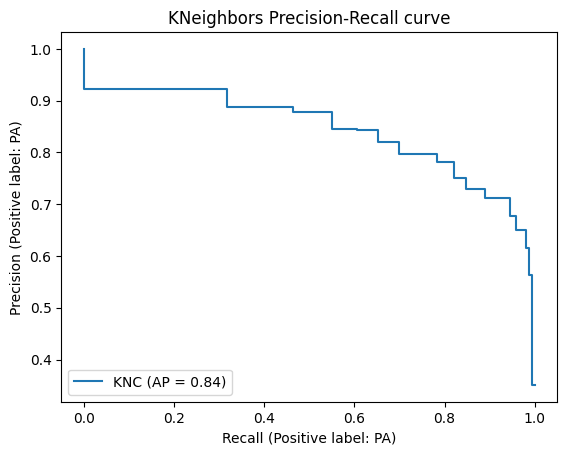

In [ ]:
#AL 
#fit KNeighbors at n = 3
KNC = KNeighborsClassifier(n_neighbors = 3)
KNC.fit(X_train, y_train)

#KNeighbors PRcurves
display = PrecisionRecallDisplay.from_estimator(
    KNC, X_test, y_test, name="KNC"
)
_ = display.ax_.set_title("KNeighbors Precision-Recall curve")

In [ ]:
#SC
# Train Logistic Regression Model - 3 Versions

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

clf = LogisticRegression(random_state=42, max_iter = 500, penalty = 'l2').fit(X_train, y_train)
clf2 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5).fit(X_train, y_train)
clf3 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'l1', solver = 'saga').fit(X_train, y_train)

y_pred_1 = clf.predict_proba(X_test)
y_pred_2 = clf2.predict_proba(X_test)
y_pred_3 = clf3.predict_proba(X_test)

print("accuracy score on training data for model 1 " + str(clf.score(X_train, y_train)))
print("accuracy score on training data for model 2 " + str(clf2.score(X_train, y_train)))
print("accuracy score on training data for model 3 " + str(clf3.score(X_train, y_train)))

print("accuracy score on test data for model 1 " + str(clf.score(X_test, y_test)))
print("accuracy score on test data for model 2 " + str(clf2.score(X_test, y_test)))
print("accuracy score on test data for model 3 " + str(clf3.score(X_test, y_test)))

accuracy score on training data for model 1 0.9958791208791209
accuracy score on training data for model 2 0.9940476190476191
accuracy score on training data for model 3 0.9917582417582418
accuracy score on test data for model 1 0.8755803156917363
accuracy score on test data for model 2 0.8792943361188487
accuracy score on test data for model 3 0.8755803156917363


[]

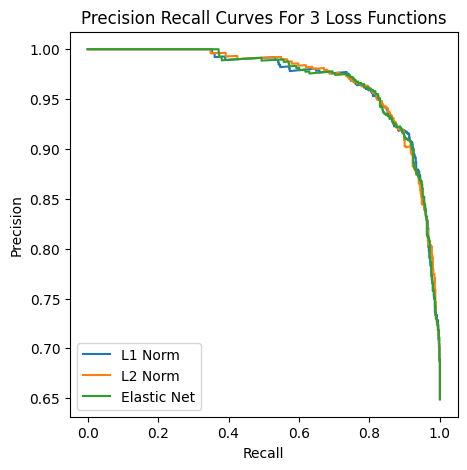

In [ ]:
#SC 
#plot pr curves for each model
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = ["NPA"])
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, y_pred_2[:,0], pos_label = ["NPA"])
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, y_pred_3[:,0], pos_label = ["NPA"])

fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_3, precision_3)
ax.plot(recall_1, precision_1)
ax.plot(recall_2, precision_2)
ax.legend(['L1 Norm', 'L2 Norm', 'Elastic Net'])
ax.set_title('Precision Recall Curves For 3 Loss Functions')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

In [18]:
#AL
#Finally, we wanted to perform cross-validation for all 5 models, 
#with the specific parameters we settled upon during individual training and valuation 

X = merged_n[union_features].values
y = classif

#evaluation dict 
cross_val = {"model" : [],
             "accuracy_test": [], 
             "accuracy_train": [], 
             "precision": [], 
             "recall" : [], 
             "f1" : []}

# Create a KFold object with k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store the models; parameters provided by Sarah and Muyoung for their models
models = {
    'KNeighbors': KNeighborsClassifier(n_neighbors=3),
    'LogisticRegression': LogisticRegression(max_iter = 500, penalty = 'l1', solver = 'saga', C=0.029471),
    'DecisionTree': DecisionTreeClassifier(max_depth=dt_depth, min_samples_leaf=dt_min_samples_leaf),
    'RandomForest': RandomForestClassifier(n_estimators=RF_n_estimators, max_depth=RF_depth, min_samples_leaf=RF_min_samples_leaf),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", n_estimators=XGB_n_estimators, max_depth=XGB_depth, random_state=42)
}


# Loop through each model and perform cross-validation
for name, model in models.items():
    accuracies = []
    precision = []
    recall = []
    f1 = []
    roc_auc = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        if name != "XGBoost":
          y_train, y_test = y[train_index], y[test_index]
        else:
          y_train, y_test = y[train_index].replace("PA", 1).replace("NPA", 0), y[test_index].replace("PA", 1).replace("NPA", 0)

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict the labels of the test data
        y_pred = model.predict(X_test)

        # Compute the accuracy score and append it to the list
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_train = model.score(X_train,y_train)
        
        if name != "XGBoost":
          _pos_label = "PA"
        else:
          _pos_label = 1
        
        #calculate and print the precision
        precision = (precision_score(y_test, y_pred, pos_label = _pos_label))

        # calculate and print the recall
        recall = (recall_score(y_test, y_pred, pos_label = _pos_label))

        # calculate and print the F1 score
        f1_sc = f1_score(y_test, y_pred, pos_label = _pos_label)
        
        cross_val["model"].append(name)
        cross_val["accuracy_test"].append(accuracy)
        cross_val["accuracy_train"].append(accuracy_train)
        cross_val["precision"].append(precision) 
        cross_val["recall"].append(recall)
        cross_val["f1"].append(f1_sc)

    # Compute the mean and standard deviation of the accuracies
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

cross_val = pd.DataFrame.from_dict(cross_val)
cross_val

,model,accuracy_test,accuracy_train,precision,recall,f1
0,KNeighbors,0.885145,0.945169,0.799127,0.863208,0.829932
1,KNeighbors,0.883436,0.943273,0.800000,0.884956,0.840336
2,KNeighbors,0.914110,0.941357,0.868313,0.897872,0.882845
3,KNeighbors,0.895706,0.939824,0.855319,0.855319,0.855319
4,KNeighbors,0.897239,0.942123,0.836653,0.889831,0.862423
5,LogisticRegression,0.880551,0.920629,0.810185,0.825472,0.817757
6,LogisticRegression,0.884969,0.913760,0.826840,0.845133,0.835886
7,LogisticRegression,0.909509,0.912610,0.903670,0.838298,0.869757
8,LogisticRegression,0.894172,0.916826,0.877273,0.821277,0.848352
9,LogisticRegression,0.901840,0.914910,0.864407,0.864407,0.864407


In [19]:
#SC and ML
#fitting and extracting top features from XGBoost model
X = merged[union_features]

#fit
XGB = xgb.XGBClassifier(objective="binary:logistic", n_estimators=_n_estimators, max_depth=depth, random_state=42)
XGB.fit(X, classif.replace({"PA": 1, "NPA": 0}))

#predict
XGB_Predict = XGB.predict_proba(X)

#get coefficients and map to features
XGB_imp = XGB.feature_importances_

XGB_fea_imp = pd.concat([pd.DataFrame(union_features), pd.DataFrame(XGB_imp)], axis = 1)
XGB_fea_imp.index = union_features
XGB_fea_imp.columns = "Features", "Importance"

print(XGB_fea_imp.nlargest(10, 'Importance')['Importance'])

COG3386    0.118896
COG3569    0.079657
COG3131    0.059740
COG0667    0.059123
COG1609    0.044944
COG0798    0.037420
COG1744    0.036591
COG0514    0.025736
COG0297    0.024760
COG1349    0.023005
Name: Importance, dtype: float32


In [ ]:
#AL and SC
#applying LR model to soil dataset

'''
#generate soil data
soil_dataset = pd.merge(soilcan, soilcog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

#normalize
scaler = StandardScaler()
soil_norm = pd.DataFrame(scaler.fit_transform(soil_dataset.iloc[:,4:]), columns = soil_dataset.iloc[:,4:].columns)
soil_norm.head()

#extract union features
X_soil = soil_norm[union_features]

#make predictions
LRPredict = LR.predict(X_soil)

soil_dataset['LRPredict'] = LRPredict
'''

In [20]:
#AL, SC and ML
#applying XGB model to soil dataset

#generate soil data
#soil_dataset = pd.merge(soilcan, soilcog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

#normalize
scaler = StandardScaler()
soil_norm = pd.DataFrame(scaler.fit_transform(soil_dataset.iloc[:,4:]), columns = soil_dataset.iloc[:,4:].columns)
soil_norm.head()

#extract union features
X_soil = soil_norm[union_features]

#make predictions
XGBPredict = XGB.predict(X_soil)

soil_dataset['XGBPredict'] = XGBPredict

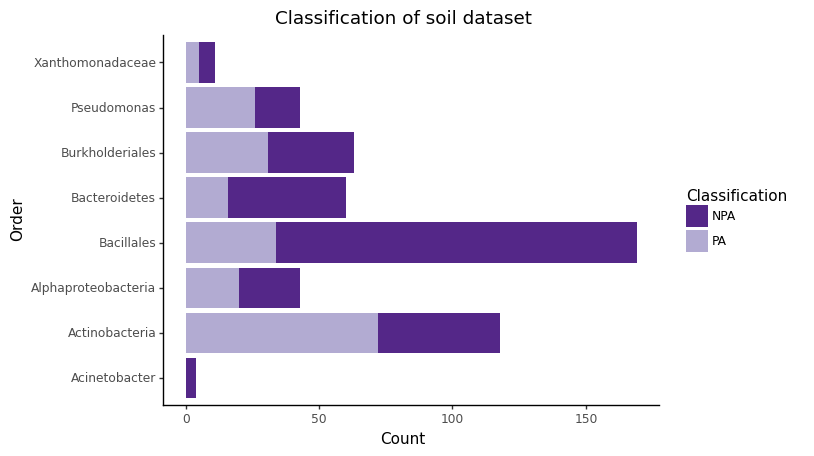

<ggplot: (8752691432349)>

In [21]:
counts = soil_dataset.groupby(['Order','XGBPredict']).size().reset_index(name = 'count')

counts["XGBPredict"] = counts["XGBPredict"].replace({1: "PA", 0: "NPA"})

# create a stacked barplot using plotnine
color_values = ['#542788', '#b2abd2','#fdae61']

order_counts = ggplot(counts, aes(x='Order', y='count', fill='XGBPredict')) + \
    geom_bar(stat='identity') + \
    labs(x = 'Order', y='Count', fill='Classification') + \
    ggtitle('Classification of soil dataset')+ \
    coord_flip() + \
    scale_fill_manual(values = color_values) + \
    theme_classic()

order_counts

In [22]:
counts["XGBPredict"] = counts["XGBPredict"].replace({1: "PA", 0: "NPA"})
counts

,Order,XGBPredict,count
0,Acinetobacter,NPA,4
1,Actinobacteria,NPA,46
2,Actinobacteria,PA,72
3,Alphaproteobacteria,NPA,23
4,Alphaproteobacteria,PA,20
5,Bacillales,NPA,135
6,Bacillales,PA,34
7,Bacteroidetes,NPA,44
8,Bacteroidetes,PA,16
9,Burkholderiales,NPA,32


In [23]:
#SC

# Visualizations and specifying some thigns
from sklearn.inspection import PartialDependenceDisplay

plt.rcParams['figure.figsize'] = [18, 5]

X_train = pd.DataFrame(X_train)
X_train.columns = union_features
     

In [25]:
#SC and ML

features = ['COG0667', 'COG3131', ('COG0667', 'COG3131')]
PartialDependenceDisplay.from_estimator(XGB, X_train, features)

KeyboardInterrupt: ignored

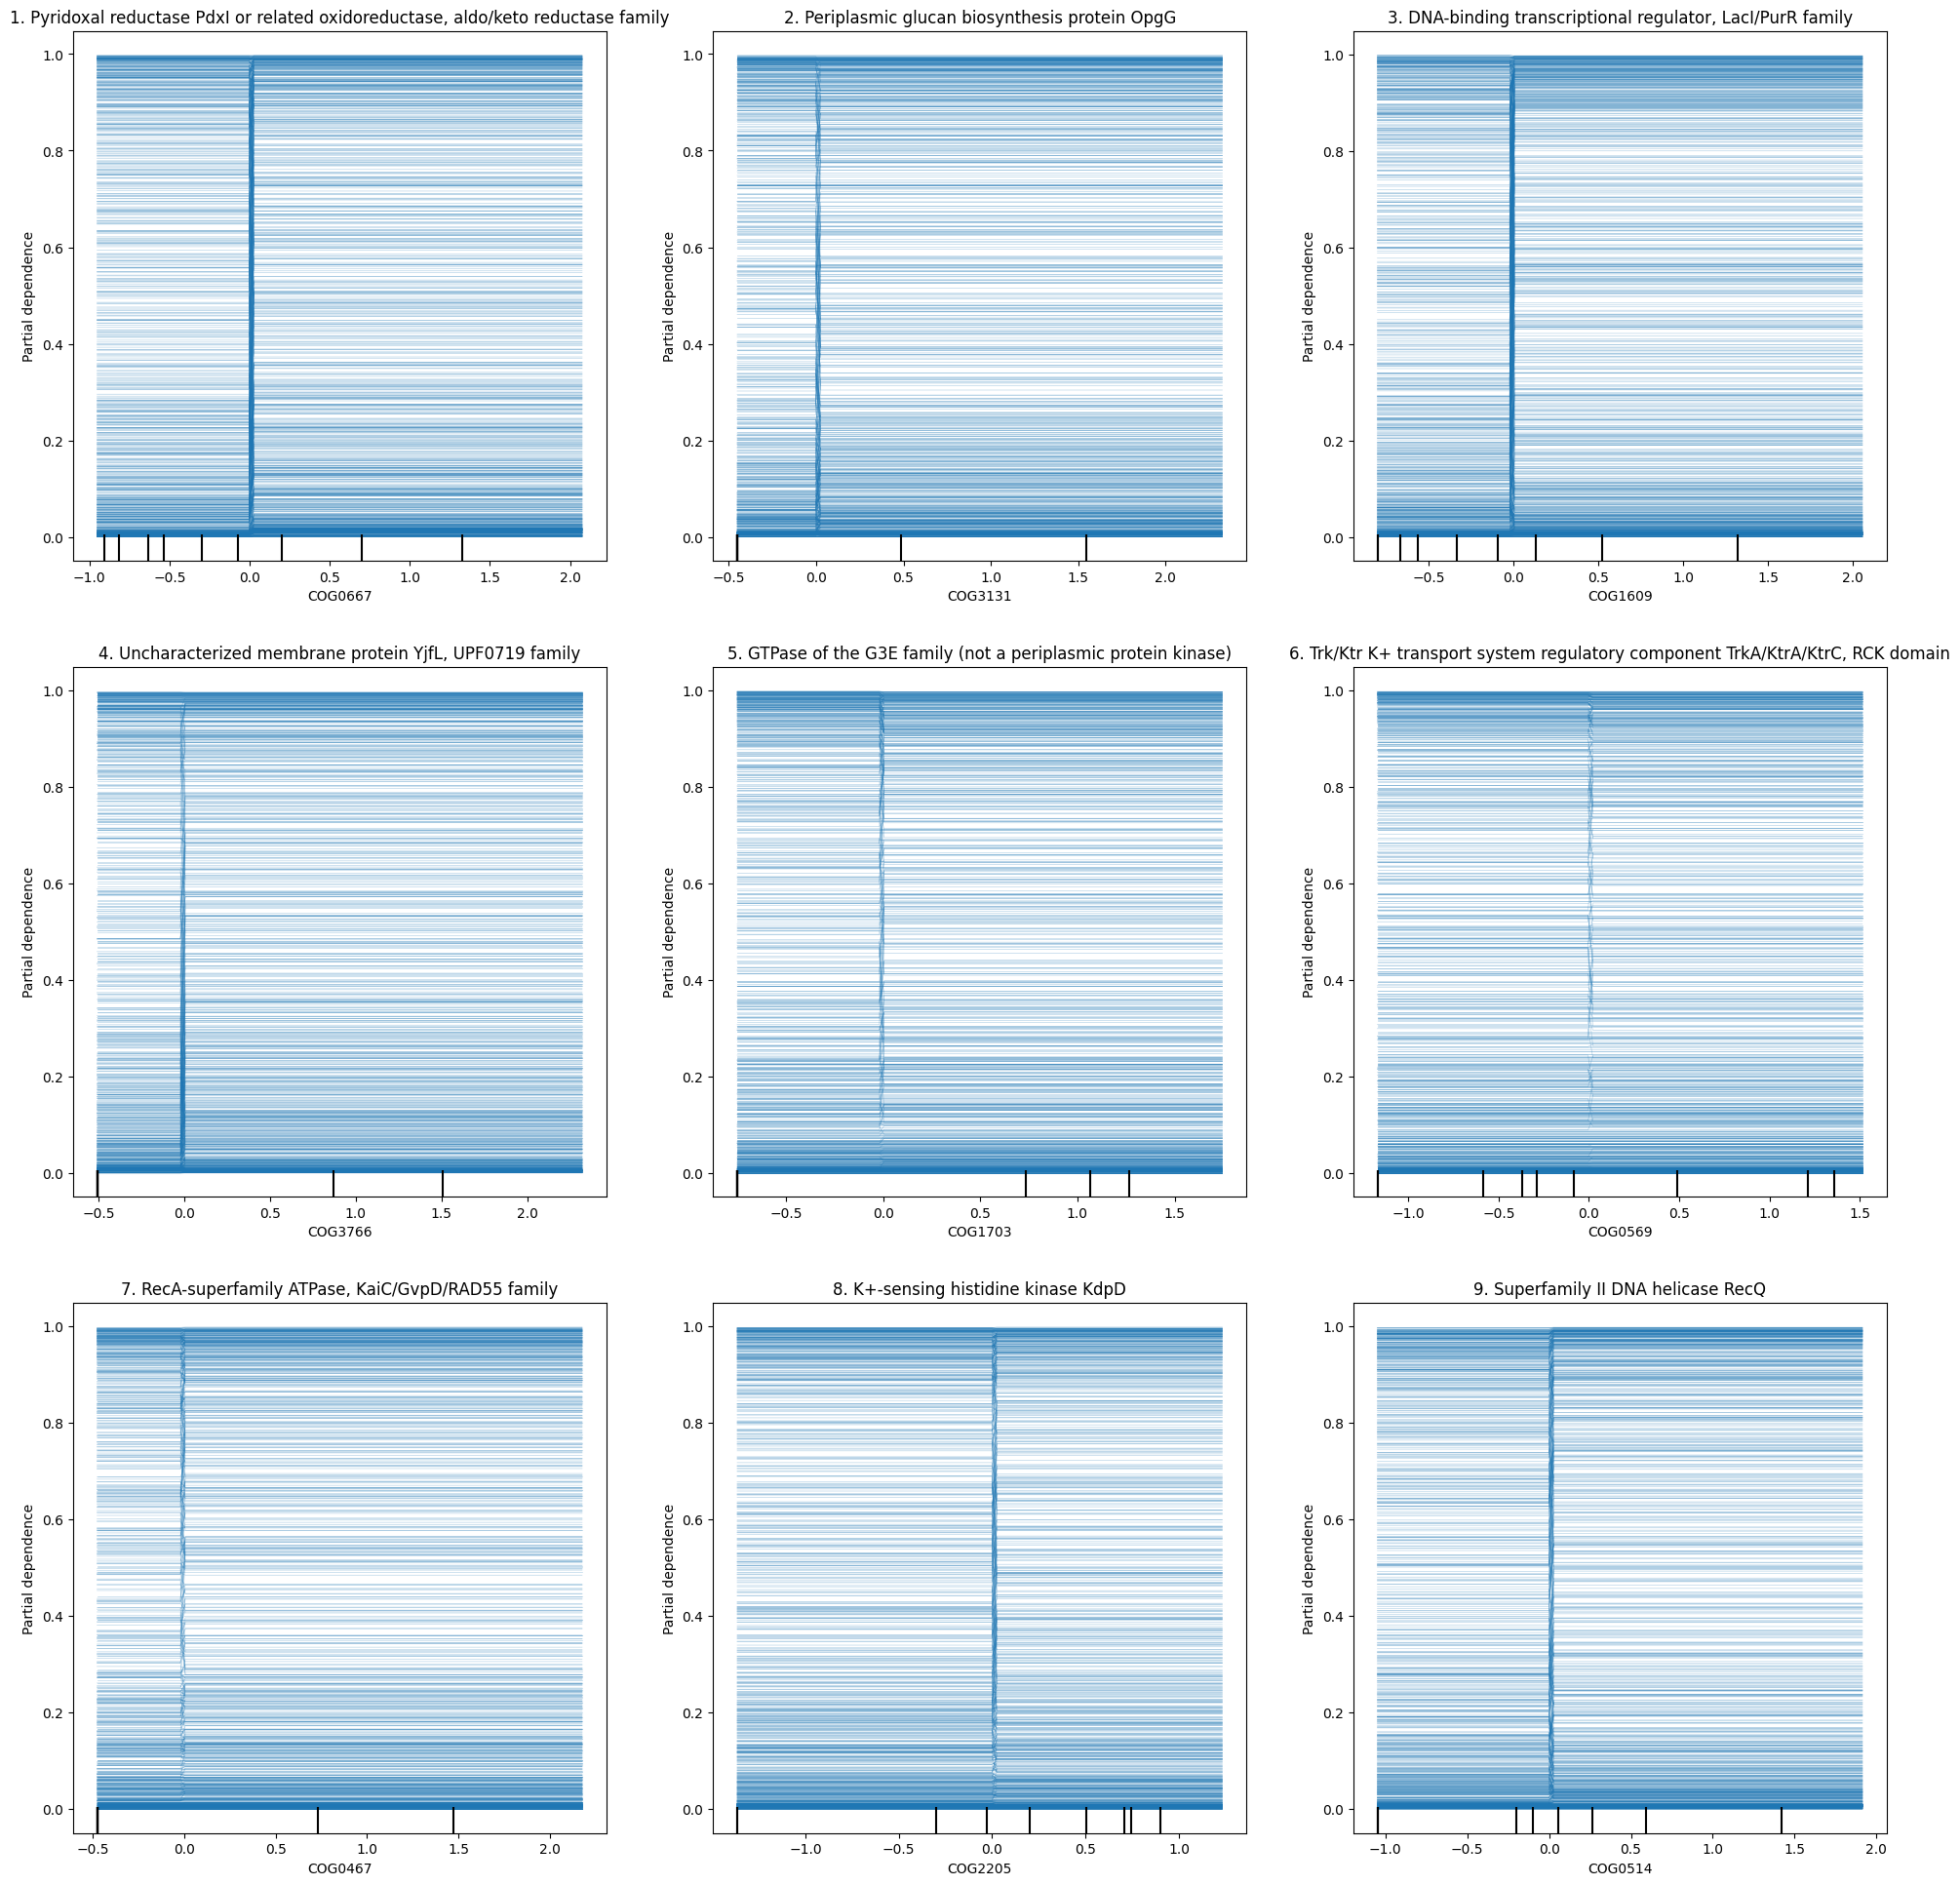

In [ ]:
#SC and ML
fig, ax = plt.subplots(3, 3, figsize =(24, 24))

# Top three feature importances

ax[0,0].set_title('1. Pyridoxal reductase PdxI or related oxidoreductase, aldo/keto reductase family')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG0667'], kind='individual' , ax = ax[0,0])

ax[0,1].set_title('2. Periplasmic glucan biosynthesis protein OpgG')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG3131'], kind='individual' , ax = ax[0,1])

ax[0,2].set_title('3. DNA-binding transcriptional regulator, LacI/PurR family')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG1609'], kind='individual' , ax = ax[0,2])

# Next top three 

ax[1,0].set_title('4. Uncharacterized membrane protein YjfL, UPF0719 family')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG3766'], kind='individual' , ax = ax[1,0])

ax[1,1].set_title('5. GTPase of the G3E family (not a periplasmic protein kinase)')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG1703'], kind='individual' , ax = ax[1,1])

ax[1,2].set_title('6. Trk/Ktr K+ transport system regulatory component TrkA/KtrA/KtrC, RCK domain')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG0569'], kind='individual' , ax = ax[1,2])

# Next top three

ax[2,0].set_title('7. RecA-superfamily ATPase, KaiC/GvpD/RAD55 family')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG0467'], kind='individual' , ax = ax[2,0])

ax[2,1].set_title('8. K+-sensing histidine kinase KdpD')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG2205'], kind='individual' , ax = ax[2,1])

ax[2,2].set_title('9. Superfamily II DNA helicase RecQ')
PartialDependenceDisplay.from_estimator(XGB, X_train, ['COG0514'], kind='individual' , ax = ax[2,2])

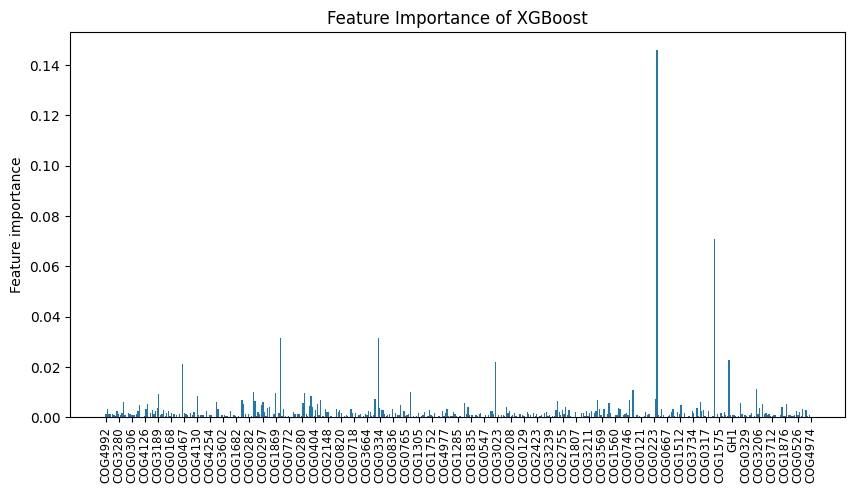

In [ ]:
# SC and ML

plt.rcParams['figure.figsize'] = [10, 5]
importance = XGB.feature_importances_

x_tick_labels = union_features[0::8]
x_tick_label_idx = np.linspace(0,len(union_features),len(x_tick_labels))

fig, ax = plt.subplots(1)
ax.bar([x for x in range(len(importance))], importance)
plt.xticks(x_tick_label_idx, x_tick_labels, size='small', rotation = 90)
ax.set_ylabel('Feature importance')
ax.set_title('Feature Importance of XGBoost')
plt.show()